In [21]:
from scipy import misc
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import tensorflow as tf
from skimage.transform import resize
import os

%matplotlib inline

In [32]:

gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

a = tf.Variable(initial_value=[1, 2, 3])
s.run(a.initializer)
s.run(a)
print(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
s.close()

[<tf.Variable 'Variable:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_1:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_2:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_3:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_4:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_5:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_6:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_7:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_8:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_9:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_10:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_11:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_12:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_13:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_14:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_15:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_16:0' shape=(3,) dtype=int32_ref>, <tf.Variable 'Variable_17

In [1]:
# %%writefile SAE.py

def add_gaussian_noise(X, stddev=0.1):
    res = X.copy()
    res += np.random.normal(size=X.shape, scale=stddev)
    return res

def add_zero_mask_noise(X, percent=0.3):
    """
    X - ndarray of vectors
    """
    res = X.copy()
    for i, x in enumerate(X):
        mask_indices = np.random.choice(np.arange(len(x)), 
                                        int(percent * len(x)),
                                        replace=False)
        res[i][mask_indices] = 0
    return res

def show_vector(vector):
    if len(vector.shape) != 3:
            vector = vector.reshape(resol)
    plt.imshow(vector)


def assemble_image(r, g, b):
    return np.stack([r, g, b], axis=2)

def assemble_image_from_vectors(r, g, b, resol):
    return np.stack([r.reshape(resol), g.reshape(resol), b.reshape(resol)], axis=2)


def load_images_to_dict(path, first=0, last=5000, resol=(256, 256), flatten=True):
    res = {
        "r": [],
        "g": [],
        "b": []
    }
    for n, file in enumerate(os.listdir(path)[first:last]):
        if file[-4:] != ".jpg":
            continue
        clear_output(True)
        print("Loading {}".format(file))
        print("{}%".format(int(n + 1 / (last-first) * 100)))
        full_dp = os.path.join(path, file)
        img = misc.imread(full_dp)
        img = resize(img, resol)
        try:
            for i, color in enumerate(["r", "g", "b"]):
                if flatten:
                    img_data = img[:,:,i].reshape([img.shape[0] * img.shape[1]])
                else:
                    img_data = img[:,:,i]
                res[color].append(img_data)
#             res["r"].append(img[:,:,0])
#             res["g"].append(img[:,:,1])
#             res["b"].append(img[:,:,2])
        except Exception:
            continue
    for k in res.keys():
        res[k] = np.array(res[k])
    return res
            


class SAE:
    
    def __init__(self, input_size, hidden_layer_sizes, ini_stddev=0.2, session=None):
        """
        Simple Stacked AutoEncoders
        
        Parameters:
            input_size: size of the input vector
            hidden_layer_sizes: list of the numbers of neurons in hidden layers (excluding output layer)
            ini_stdev: standard deviation for gaussian weights & biases initialization
            session: TensorFlow session
        """
        assert len(hidden_layer_sizes) > 0, "Invalid hidden layer sizes. List of ints expected"
#         assert np.all(hidden_layer_sizes[i] == hidden_layer_sizes[len(hidden_layer_sizes) - 1 - i] 
#                       for i in range(len(hidden_layer_sizes))), "Hidden layer sizes must be symmetric"
        # Configuring TF
        if session is None:
            gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)
            self.session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
        else: 
            self.session = session
        self.hidden_layer_sizes = hidden_layer_sizes
        # Creating AE
        self.weights = []
        self.biases = []
        # First layer:
        first_w = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[input_size, hidden_layer_sizes[0]]), 
                            dtype="float32", name="w_0")
        first_b = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[hidden_layer_sizes[0]]), 
                              dtype="float32", name="b_0")
        self.weights.append(first_w)
        self.biases.append(first_b)
        for i in range(0, len(hidden_layer_sizes) - 1):
            next_layer_size = hidden_layer_sizes[i + 1]
            w = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[hidden_layer_sizes[i], next_layer_size]), 
                            dtype="float32", name="w_{}".format(i + 1))
            b = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[next_layer_size]), 
                            dtype="float32", name="b_{}".format(i + 1))
            self.weights.append(w)
            self.biases.append(b)
        last_w = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[hidden_layer_sizes[-1], input_size]), 
                             dtype="float32", name="w_last")
        last_b = tf.Variable(initial_value=np.random.normal(scale=ini_stddev, size=[input_size]), 
                             dtype="float32", name="b_last")
        self.weights.append(last_w)
        self.biases.append(last_b)
        
        # Creating layers
        self.input_tensor = tf.placeholder("float32", shape=[None, input_size])
        self.layers = []
        self.output_layer = None
        first_layer = tf.nn.sigmoid(tf.matmul(self.input_tensor, first_w) + first_b)
        self.layers.append(first_layer)
        self.output_layer = first_layer
        for i in range(1, len(self.weights)):
            w = self.weights[i]
            b = self.biases[i]
            layer = tf.nn.sigmoid(tf.matmul(self.output_layer, w) + b)
            self.layers.append(layer)
            self.output_layer = layer
            
#         print(self.hidden_layer_sizes)
#         print(self.layers)
        
        
    def __train_epoch(self, X, optimizer, loss):
        optimizer.run({self.input_tensor: X}, session=self.session)
        return loss.eval({X: X}, s)

    def __get_batch(X, size):
        ind = np.random.choice(np.arange(X.shape[0]), replace=False, size=size)
        return X[ind]

    def __train_greedy(self, X, n_epochs, optimizer_obj, batch_size=None, min_delta=1e-5):
        # Training layer-wise
        for i in range(len(self.layers[:-1])):
            report_str = "Training layer {} out of {}".format(i + 1, len(self.layers))
            layer = self.layers[i]
            fake_w = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[self.hidden_layer_sizes[i], X.shape[1]]), 
                                 dtype="float32", name="fake_w_{}".format(i))
            fake_b = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[X.shape[1]]), 
                                 dtype="float32", name="fake_b_{}".format(i))
            fake_output_layer = tf.nn.sigmoid(tf.matmul(layer, fake_w) + fake_b)
            loss = tf.losses.mean_squared_error(X, fake_output_layer)
            optimizer = optimizer_obj.minimize(loss, var_list=[self.weights[i], self.biases[i], fake_w, fake_b])
            prev_loss = .0
            init_new_vars_op = tf.initialize_variables([fake_w, fake_b])
            self.session.run(init_new_vars_op)
            for epoch in range(n_epochs):
                if batch_size is not None:
                    X_train = self.__get_batch(X, batch_size)
                else:
                    X_train = X
                curr_loss = self.__train_epoch(X_train, optimizer, loss)
                delta = abs(curr_loss - prev_loss)
                if delta <= min_delta:
                    break
                clear_output(True)
                print(report_str)
                print("Epoch: {}\nLoss: {}".format(epoch + 1, curr_loss))
            if i == len(self.layers[:-2]):
                self.weights[i + 1] = fake_w
                self.biases[i + 1] = fake_b

    def __train(self, X, n_epochs, optimizer_obj, batch_size=None, min_delta=1e-5):
        print("NOT IMPLEMENTED")
        return
        loss = tf.losses.mean_squared_error(X, self.output_layer)
        optimizer = optimizer_obj.minimize(loss)

    def fit(self, X, n_epochs, optimizer_obj, batch_size=None, min_delta=1e-5, greedy=True):
        """
        Train the SDAE

        Parameters:
            X: ndarray of training vectors
            optimizer_obj: algorithm for optimization (need to pass the object from tensorflow.train)
            batch_size: for stochastic training
        """
        self.session.run(tf.global_variables_initializer())
        self.session.run(tf.local_variables_initializer())
        if greedy:
            self.__train_greedy(X, n_epochs, optimizer_obj, batch_size, min_delta)
        else:
            self.__train(X, n_epochs, optimizer_obj, batch_size, min_delta)


    def predict(self, sample):
        return self.out_layer.eval({X: sample}, self.session)
        



In [21]:
dataset_path = "./kagglecatsanddogs_3367a/PetImages/Cat"
resol = (128, 128)

In [12]:
X = load_images_to_dict(dataset_path, last=5, resol=resol, flatten=True)

Loading 1000.jpg
24%


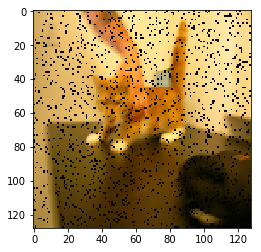

In [13]:
n = 0
plt.imshow(add_zero_mask_noise(assemble_image_from_vectors(X["r"][n], X["g"][n], X["b"][n], resol), percent=0.1))

In [14]:
input_size = X["r"][0].shape[0]
input_size

16384

In [27]:
sae = SAE(input_size, [4096, 1024, 4096])

C:\Users\Konstantin\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
sae.fit(add_zero_mask_noise(X["r"], percent=0.1), 300, tf.train.RMSPropOptimizer(0.05))

In [9]:
latent_size = 8000

w_hid = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[input_size, latent_size]), dtype="float32")
b_hid = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size]), dtype="float32")

w_r_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size, input_size]), dtype="float32")
b_r_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[input_size]), dtype="float32")

w_g_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size, input_size]), dtype="float32")
b_g_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[input_size]), dtype="float32")

w_b_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[latent_size, input_size]), dtype="float32")
b_b_out = tf.Variable(initial_value=np.random.normal(scale=0.2, size=[input_size]), dtype="float32")

X_in = tf.placeholder("float32", shape=[None, input_size])

In [10]:
learning_rate = 0.05

latent_layer = tf.nn.sigmoid(tf.matmul(X_in, w_hid) + b_hid)

out_layer_r = tf.nn.sigmoid(tf.matmul(latent_layer, w_r_out) + b_r_out)
# out_layer_g = tf.nn.sigmoid(tf.matmul(latent_layer, w_g_out) + b_g_out)
# out_layer_b = tf.nn.sigmoid(tf.matmul(latent_layer, w_b_out) + b_b_out)

# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=X_in_clear, labels=out_wo_activ))
loss_r = tf.losses.mean_squared_error(X_in, out_layer_r)
# loss_g = tf.losses.mean_squared_error(X_in, out_layer_g)
# loss_b = tf.losses.mean_squared_error(X_in, out_layer_b)

# optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, var_list=[w_hid, b_hid, w_out, b_out])
optimizer_r = tf.train.RMSPropOptimizer(learning_rate).minimize(loss_r)
# optimizer_g = tf.train.RMSPropOptimizer(learning_rate).minimize(loss_g)
# optimizer_b = tf.train.RMSPropOptimizer(learning_rate).minimize(loss_b)

def train_epoch(X):
    optimizer_r.run({X_in: X}, session=s)
#     optimizer_g.run({X_in: X}, session=s)
#     optimizer_b.run({X_in: X}, session=s)
    return loss_r.eval({X_in: X}, s)

def latent_repr(X):
    return latent_layer.eval({X_in: X}, s)

def predict(X_r, X_g, X_b):
    channels = (out_layer_r.eval({X_in: X_r}, s).reshape(resol), 
                out_layer_g.eval({X_in: X_g}, s).reshape(resol),
                out_layer_b.eval({X_in: X_b}, s).reshape(resol))
    return np.stack(channels, axis=2)

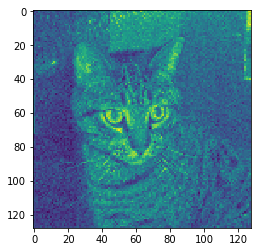

In [ ]:
imshow(add_noise(X["g"][1], 0.05))

In [ ]:
batch_size = 1000
epochs = 300

s.run(tf.global_variables_initializer())

for i in range(epochs):
    out_batch = X["r"][np.random.choice(range(X["r"].shape[0]), size = [batch_size], replace=False)]
    in_batch = add_noise(out_batch, 0.05)
#     in_batch = out_batch

    loss_r = train_epoch(in_batch, out_batch)
    clear_output(True)
    print("Epoch: {}\nLoss R: {}".format(i + 1, loss_r))
